# Import libraries

In [ ]:
from google.colab import drive
import os
import shutil
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights, ResNet101_Weights, ResNet152_Weights
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import random
import numpy as np
from collections import defaultdict
import math

# Extract data and create dataset

In [ ]:
drive.mount('/content/gdrive')

In [ ]:
!unzip -q -o gdrive/MyDrive/Adaptiope.zip 

In [ ]:
classes = ["/backpack", "/bookcase", "/car jack", "/comb", "/crown", "/file cabinet", "/flat iron", "/game controller", "/glasses",
           "/helicopter", "/ice skates", "/letter tray", "/monitor", "/mug", "/network switch", "/over-ear headphones", "/pen",
           "/purse", "/stand mixer", "/stroller"]

for d, td in zip(["Adaptiope/product_images", "Adaptiope/real_life"], ["adaptiope_small/product_images", "adaptiope_small/real_life"]):
  os.makedirs(td)
  for c in tqdm(classes):
    c_path = ''.join((d, c))
    c_target = ''.join((td, c))
    shutil.copytree(c_path, c_target)

# Create dataloader

This code defines a function `get_data()` and it takes four parameters as input:


*   `batch_size`: the number of data samples per batch to be loaded in memory at a time 
*   `product_root`: the path to the directory containing the source domain images.
*   `real_root`: the path to the directory containing the target domain images.
*   `num_ops`: number of data augmentations for RandArgument transformation.
*   `magnitude`: size of the data augmentations for RandArgument transformation.


The function creates two separate lists of transformations, one is a soft transformation which contains Resize, RandomCrop and normalization, the other is strong transformation which contains all the previous transformation and RandArgument.

After that, we created four separate datasets, one for the source domain with soft transformation, one for the target domain with soft transformation, one for the source domain with strong transformation and one for the target domain with strong transformation.

Next, the code splits the data into training and test sets, using 80% of the data for training and 20% for testing. Then it uses the RandomSampler class to randomly sample from the source and target datasets during training, which helps to prevent overfitting.

Finally, the code creates four data loaders, one for each dataset. The data loaders are PyTorch objects that allow easy iteration through the data, loading batches of images in memory as needed during training.


In [ ]:
def get_data(batch_size, product_root, real_root, num_ops=2, magnitude=10):
  # resizing and cropping
  # prepare data transformations for the train loader
  transform = list()
  transform.append(T.Resize((256, 256)))                      # resize each PIL image to 256 x 256
  transform.append(T.RandomCrop((224, 224)))                 # randomly crop a 224 x 224 patch
  transform.append(T.ToTensor())                              # convert Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225]))    # normalize with ImageNet mean
  
  # compose the above transformations into weak and strong (which has RandAugment in addition)
  transform_weak = T.Compose(transform.copy())
  transform_strong = T.Compose(transform.copy())                           
  transform_strong.transforms.insert(0, T.RandAugment(num_ops, magnitude))
    
  # load data
  dataset_prod = torchvision.datasets.ImageFolder(root=product_root, transform=transform_weak)
  dataset_prod_aug = torchvision.datasets.ImageFolder(root=product_root, transform=transform_strong)
  dataset_real = torchvision.datasets.ImageFolder(root=real_root, transform=transform_weak)
  dataset_real_aug = torchvision.datasets.ImageFolder(root=real_root, transform=transform_strong)
  
  # create train and test splits (80/20)
  num_samples = len(dataset_prod) # same number of samples among datasets
  training_samples = int(num_samples * 0.8 + 1)
  test_samples = num_samples - training_samples

  train_data_prod, test_data_prod = torch.utils.data.random_split(dataset_prod, [training_samples, test_samples], generator=torch.Generator().manual_seed(1))
  train_data_prod_aug, test_data_prod_aug = torch.utils.data.random_split(dataset_prod_aug, [training_samples, test_samples], generator=torch.Generator().manual_seed(1))
  train_data_real, test_data_real = torch.utils.data.random_split(dataset_real, [training_samples, test_samples], generator=torch.Generator().manual_seed(2))
  train_data_real_aug, test_data_real_aug = torch.utils.data.random_split(dataset_real_aug, [training_samples, test_samples], generator=torch.Generator().manual_seed(2))

  # initialize sampler to get same data from weak and augment
  sampler_prod = torch.utils.data.RandomSampler(train_data_prod, generator=torch.Generator().manual_seed(1))
  sampler_prod_aug = torch.utils.data.RandomSampler(train_data_prod_aug, generator=torch.Generator().manual_seed(1))
  sampler_real = torch.utils.data.RandomSampler(train_data_real, generator=torch.Generator().manual_seed(2))
  sampler_real_aug = torch.utils.data.RandomSampler(train_data_real, generator=torch.Generator().manual_seed(2))

  # initialize dataloaders
  train_loader_prod = torch.utils.data.DataLoader(train_data_prod, batch_size, sampler=sampler_prod)
  test_loader_prod = torch.utils.data.DataLoader(test_data_prod, batch_size, shuffle=False)
  train_loader_prod_aug = torch.utils.data.DataLoader(train_data_prod_aug, batch_size, sampler=sampler_prod_aug)
  test_loader_prod_aug = torch.utils.data.DataLoader(test_data_prod_aug, batch_size, shuffle=False)
  
  train_loader_real = torch.utils.data.DataLoader(train_data_real, batch_size, sampler=sampler_real)
  test_loader_real = torch.utils.data.DataLoader(test_data_real, batch_size, shuffle=False)
  train_loader_real_aug = torch.utils.data.DataLoader(train_data_real_aug, batch_size, sampler=sampler_real_aug)
  test_loader_real_aug = torch.utils.data.DataLoader(test_data_real_aug, batch_size, shuffle=False)
  
  return (train_loader_prod, test_loader_prod), (train_loader_prod_aug, test_loader_prod_aug), (train_loader_real, test_loader_real), (train_loader_real_aug, test_loader_real_aug)

# Create model

In accordance with the paper titled "Transferable Attribute Learning for Multi-Source Domain Adaptation" by authors Zhongying Deng, Kaiyang Zhou, Yongxin Yang, Tao Xiang, available at the following link: https://arxiv.org/pdf/2111.03911.pdf, we have implemented the proposed method, referred to as DAC-Net, in the form of computer code.

The paper presents a new approach to multi-source domain adaptation (MSDA) called transferable attribute learning. The main idea is that different domains have different visual appearances but they contain the same classes characterized by the same set of attributes. The authors propose a new model called DAC-Net, which uses a feature channel attention module to identify transferable features (attributes). The attention module is supervised by a consistency loss, which is imposed on the distributions of channel attention weights between source and target domains. Additionally, to improve the discriminative feature learning on the target data, the authors use pseudo-labeling and class compactness loss to minimize the distance between the target features and the classifier's weight vectors.

### Channel attention module

With attention modeling for each image, DAC-Net is encouraged to use a subset of the feature channels to explain the image content, therefore facilitating the discovery of transferable latent attributes.

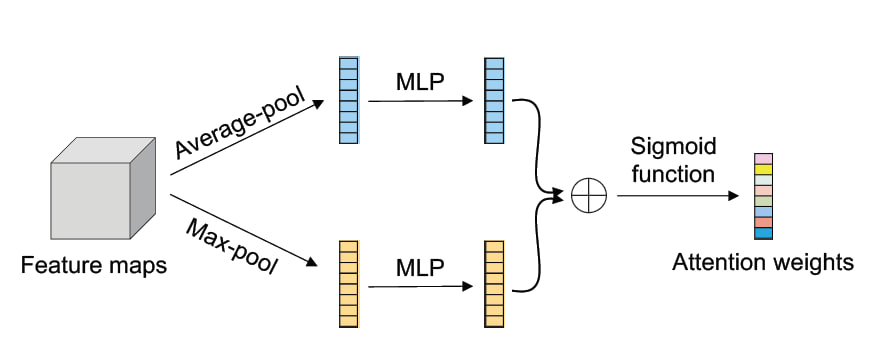

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

### Discriminator module

In [ ]:
class DiscriminatorConv(nn.Module):
    def __init__(self, c1, num_convs=2):
        super().__init__()
        self.rev = GradientReversal()

        dis_tower = []
        for _ in range(num_convs):
            dis_tower.append(
                nn.Conv2d(
                    c1,
                    c1,
                    kernel_size=3,
                    stride=1,
                    padding=1
                )
            )
            dis_tower.append(nn.GroupNorm(32, c1))
            dis_tower.append(nn.ReLU())

        self.add_module('dis_tower', nn.Sequential(*dis_tower))

        self.cls_logits = nn.Conv2d(
            c1, 1, kernel_size=3, stride=1,
            padding=1
        )

        # initialization
        for modules in [self.dis_tower, self.cls_logits]:
            for l in modules.modules():
                if isinstance(l, nn.Conv2d):
                    torch.nn.init.normal_(l.weight, std=0.01)
                    torch.nn.init.constant_(l.bias, 0)
    
    def forward(self, x, lambda_):
        x = self.rev(x, lambda_)
        
        x = self.dis_tower(x)
        x = self.cls_logits(x)
        return x


class GradientReversal(torch.nn.Module):
    def __init__(self):
        super(GradientReversal, self).__init__()

    def forward(self, x, lambda_):
        return GradientReversalFunction.apply(x, lambda_)


class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None

### BasicBlock and Bottleneck modules of ResNet

The architecture is described by the class `BasicBlock`, which includes two convolutional layers, batch normalization layers, and a ReLU activation function. The `BasicBlock` also includes a ChannelAttention module, which has been described in the previous section. The basic block also includes options for downsampling, using attention, and outputting attention weights. The forward method of the basic block applies these operations to the input data, x, and returns the output of the block. The final output of the network is a tensor, which can be used for further analysis or classification. The class `Bottleneck` can be used in bigger ResNet architecture, to increase the capacity of the model to learn more complex features from the input data. However, this also increases the number of parameters in the network and thus requires more resources to train and run. Please refer to the image provided for a complete description of the architecture.

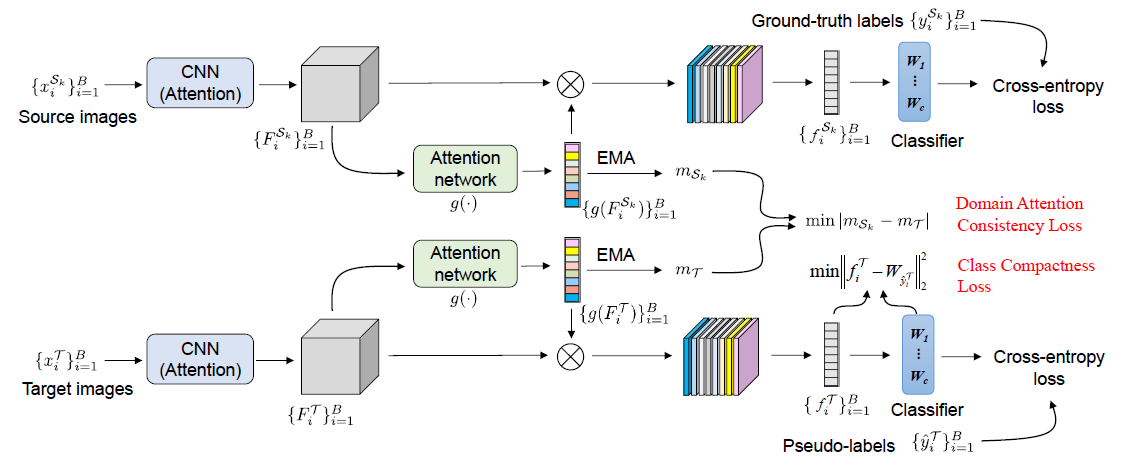

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_attention=True, output_attention=False):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.ca = ChannelAttention(planes)
        self.downsample = downsample
        self.stride = stride
        self.output_attention = output_attention
        self.use_attention = use_attention

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if self.use_attention:
            out_ca = self.ca(out)
            out = residual + out_ca * out
        else:
            out = residual + out
            out_ca = []
        out = self.relu(out)
        if self.output_attention:
            return out, out_ca
        else:
            return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_attention=True, output_attention=False):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, planes * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.ca = ChannelAttention(planes * self.expansion)
        self.downsample = downsample
        self.stride = stride
        self.output_attention = output_attention
        self.use_attention = use_attention

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if self.use_attention:
            out_ca = self.ca(out)
            out = residual + out_ca * out
        else:
            out = residual + out
            out_ca = []
        out = self.relu(out)
        if self.output_attention:
            return out, out_ca
        else:
            return out

### ResNet architecture with channel attention

The `ResNet` class initializes the ResNet architecture by defining the convolutional, batch normalization and pooling layers. The architecture of the ResNet is defined by the input parameters `block` and `layers`. The class has several methods, the `_make_layer` method creates the layers of the architecture, the `_init_params` method initializes the parameters of the layers, and the `featuremaps` method returns the feature maps of the input data. The architecture also includes an attention mechanism, which is controlled by the `use_attention` parameter. Additionally, the architecture includes a DiscriminatorConv layer, an AdaptiveAvgPool2d layer and a Linear layer.

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers):
        self.inplanes = 64
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], use_attention=False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, use_attention=False)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, use_attention=True)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, use_attention=True)
        self.disc = DiscriminatorConv(512 * block.expansion)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 1000)

        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        #     elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        #         nn.init.constant_(m.weight, 1)
        #         nn.init.constant_(m.bias, 0)

        self._init_params()


    def _make_layer(self, block, planes, blocks, stride=1, use_attention=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_attention=use_attention))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == blocks - 1:
                layers.append(block(self.inplanes, planes, output_attention=True, use_attention=use_attention))
            else:
                layers.append(block(self.inplanes, planes, use_attention=use_attention))

        return nn.Sequential(*layers)

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu'
                )
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def featuremaps(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x, out_ca1 = self.layer1(x)
        x, out_ca2 = self.layer2(x)
        x, out_ca3 = self.layer3(x)
        x, out_ca4 = self.layer4(x)
        return x, [out_ca1, out_ca2, out_ca3, out_ca4]

    def predictions(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def forward(self, x, lambda_=0, gamma=0):
        f, channel_attention = self.featuremaps(x)

        # domain = self.disc(f, lambda_)
        domain = self.disc(channel_attention[-1]*f*gamma + f*(1-gamma), lambda_)

        v = self.avgpool(f)

        out = self.predictions(v)
        
        return out, v, channel_attention, domain

### Get model function

The function `get_model` takes in three arguments: `resnet`, `pretrained` and `num_classes`. The function creates an instance of the ResNet model with a specific architecture (determined by the resnet argument) and layers configuration. The argument resnet can take one of the values 18, 34, 50, 101, 152. If the `pretrained` argument is set to `True`, the function loads the pre-trained weights of the model. The final fully connected layer of the model is then modified to have `num_classes` output neurons. The function returns the created model.

In the project, the default version of ResNet with the `BasicBlock` and `layers =[2, 2, 2, 2]` was used consistently. However, the code for other versions of ResNet such as ResNet with `Bottleneck` and different number of layers were included for completeness.

In [ ]:
def get_model(resnet=18, pretrained=False, num_classes=20):
  if resnet == 18:
    model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2])
    weights = ResNet18_Weights.IMAGENET1K_V1
  elif resnet == 34:
    model = ResNet(block=BasicBlock, layers=[3, 4, 6, 3])
    weights = ResNet34_Weights.IMAGENET1K_V1
  elif resnet == 50:
    model = ResNet(block=Bottleneck, layers=[3, 4, 6, 3])
    weights = ResNet50_Weights.IMAGENET1K_V1
  elif resnet == 101:
    model = ResNet(block=Bottleneck, layers=[3, 4, 23, 3])
    weights = ResNet101_Weights.IMAGENET1K_V1
  elif resnet == 152:
    model = ResNet(block=Bottleneck, layers=[3, 8, 36, 3])
    weights = ResNet152_Weights.IMAGENET1K_V1
  else:
    print("Unable to identify the ResNet architecture")
    return

  if pretrained:
    model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

  model.fc = nn.Linear(model.fc.in_features, num_classes)

  return model

# Specify optimizer and scheduler

The `get_optimizer` function takes in a PyTorch model, a learning rate, weight decay, momentum, and an optimization algorithm as input parameters. It then creates an optimizer object based on the specified algorithm, and sets the learning rate, weight decay, and momentum accordingly. It returns the optimizer object.

The `get_scheduler` function takes in an optimizer, the number of training epochs, and a learning rate scheduling algorithm as input parameters. It then creates a learning rate scheduler object based on the specified algorithm, and sets the number of training epochs accordingly. It returns the scheduler object.

During the experiment, we always used the optimizer `Adam`, with a `learning rate= 5e-4`, `epoches=20` and the scheduler `cosine` for the learning rate schedule.

In [ ]:
def get_optimizer(model, lr, wd=0, momentum=0, opt='Adam'):
  if opt == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  elif opt == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  
  return optimizer

In [ ]:
def get_scheduler(optimizer, epochs, sched='cosine'):
  if sched == 'cosine':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
  
  return scheduler

# Train model

This code is defining a training step function for training a model on a dataset. The function takes in several parameters including the model, the training data loaders for the source and target datasets, the optimizer, and several weight parameters for different losses. The function then iterates over the source training data, and for each batch, it calculates several different losses:
*   **Supervised loss:** It is calculated using the cross-entropy loss function on the output of the model for the source data and the corresponding labels.
*   **Unsupervised pseudo loss:** TIt is calculated by applying a cross-entropy loss between the target dataset with the strong transformation and the pseudo labels generated from the output of the model on the target dataset with weak transformation, with the additional constraint of only considering samples with a high confidence level as determined by a threshold.
*   **Domain attention consistency loss:** It is calculated using the attention maps generated by the model. The purpose of this loss is to minimize the distribution divergence of channel attention weights between
each pair of source and target domains.
*   **Compactness loss:** It encourages the target features to be close to the corresponding classification weight vectors. Essentially, the loss
pulls together the target features and the classifier’s weight vectors to facilitate discriminative target feature learning.
*   **Adversarial loss:**



In [ ]:
def training_step(model, source_train_loader, target_train_loader, optimizer, 
                  pseudo=0., attn=0., comp=0., adv=0., device='cuda:0', show_img=False, ep=False):
  
  source_train_loader, source_train_loader_aug = source_train_loader
  target_train_loader, target_train_loader_aug = target_train_loader

  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_accuracy = 0.

  weight_pseudo = pseudo
  weight_attn = attn
  weight_comp = comp
  weight_adv = adv

  ema_alpha = 0.999
  tar_ca_last1 = torch.tensor(1.)
  tar_ca_last2 = torch.tensor(1.)
  src_ca_last1 = torch.tensor(1.)
  src_ca_last2 = torch.tensor(1.)

  conf_threshold = 0.95

  mloss_source = torch.zeros(1)
  mloss_pseudo = torch.zeros(1)
  mloss_attn = torch.zeros(1)
  mloss_comp = torch.zeros(1)
  mloss_adv = torch.zeros(1)

  if show_img:
    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
    std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)
  
  target_iter = iter(target_train_loader)
  target_iter_aug = iter(target_train_loader_aug)

  # strictly needed if network contains layers which has different behaviours between train and test
  model.train()

  pbar = tqdm(zip(source_train_loader, source_train_loader_aug), total=len(source_train_loader))

  epoch, epochs = ep
  nb = len(source_train_loader)
  max_iterations = nb * epochs

  for i, ((inputs_source, targets_source), (inputs_source_aug, _)) in enumerate(pbar):
    
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
      inputs_target_aug, _ = next(target_iter_aug)
    except:
      target_iter = iter(target_train_loader)
      target_iter_aug = iter(target_train_loader_aug)

      inputs_target, _ = next(target_iter)
      inputs_target_aug, _ = next(target_iter_aug)

    # input_weak = torch.cat([inputs_source, inputs_target], dim=0) 
    # input_strong = torch.cat([inputs_source_aug, inputs_target_aug], dim=0)

    targets_domain = torch.cat(
        (torch.zeros(inputs_source.shape[0]), torch.ones(inputs_target.shape[0]))
    ).unsqueeze(dim=1)

    # load data into device
    inputs_source, inputs_target = inputs_source.to(device), inputs_target.to(device)
    # input_weak, input_strong = input_weak.to(device), input_strong.to(device)
    inputs_target_aug = inputs_target_aug.to(device)
    targets_source, targets_domain = targets_source.to(device), targets_domain.to(device)


    # -----------------------------------
    # Supervised loss
    # -----------------------------------

    output_source, _, ca_source, _ = model(inputs_source)
    loss_source = F.cross_entropy(output_source, targets_source)


    # -----------------------------------
    # Generate artificial label
    # -----------------------------------

    with torch.no_grad():
      output_weak, _, _, _ = model(inputs_target)
      max_prob, label_weak = F.softmax(output_weak, dim=1).max(dim=1)
      mask_pseudo = (max_prob >= conf_threshold).float()


    # -----------------------------------
    # Unsupervised pseudo loss
    # -----------------------------------
    
    loss_pseudo = torch.tensor(0.).to(device)

    if pseudo:
      output_strong, feat_strong, ca_strong, _ = model(inputs_target_aug)
      loss_pseudo = F.cross_entropy(output_strong, label_weak, reduction='none')
      loss_pseudo = (loss_pseudo * mask_pseudo).mean()

    # -----------------------------------
    # Domain attention consistency loss
    # -----------------------------------

    loss_attn = torch.tensor(0.).to(device)

    if attn:
      # DAC loss for the fourth residual block
      mean_tar_ca1 = tar_ca_last1 * ema_alpha + (1. - ema_alpha) * torch.mean(ca_strong[-1], 0)
      tar_ca_last1 = mean_tar_ca1.detach()

      mean_src_ca1 = src_ca_last1 * ema_alpha + (1. - ema_alpha) * torch.mean(ca_source[-1], 0)
      src_ca_last1 = mean_src_ca1.detach()

      loss_attn += torch.mean(torch.abs(mean_src_ca1 - mean_tar_ca1))

      # DAC loss for the third residual block
      mean_tar_ca2 = tar_ca_last2 * ema_alpha + (1. - ema_alpha) * torch.mean(ca_strong[-2], 0)
      tar_ca_last2 = mean_tar_ca2.detach()

      mean_src_ca2 = src_ca_last2 * ema_alpha + (1. - ema_alpha) * torch.mean(ca_source[-2], 0)
      src_ca_last2 = mean_src_ca2.detach()

      loss_attn += torch.mean(torch.abs(mean_src_ca2 - mean_tar_ca2))


    # -----------------------------------
    # Class compactness loss
    # -----------------------------------
    
    loss_comp = torch.tensor(0.).to(device)

    if comp:
      with torch.no_grad():
        img_shape = inputs_target.shape

        # enforce class compactness loss only on target samples that have consistent prediction under Guassian noise
        noise = torch.randn(img_shape[0], img_shape[1], img_shape[2], img_shape[3]) * 0.15
        input_noise = torch.flip(inputs_target, [3]) + noise.to(device)
        output_noise, feat_noise, _, _ = model(input_noise)
        max_prob, label_noise = F.softmax(output_noise, dim=1).max(1)
        mask_noise = (max_prob >= conf_threshold).float()

        # create mask to filter samples whose prediction is not consistent under Guassian noise
        # or that under weak augmentation or noise where predicted with confidence below threshold
        label_cons = (label_weak == label_noise).float()
        mask_cons = mask_pseudo * mask_noise * label_cons

        if mask_cons.sum() > 0: # check if there is at least one sample that satisfy the contraints
          weight = model.fc.weight
          # feat_strong has shape [60, 512, 1, 1] while weight[label_weak, :] has shape [60, 512]
          # so squeeze feat_strong to shape [60, 512], removing unnecessary dimensions
          # moreover, mask_cons has shape [60] thus unsqueeze to [60, 1] to have same number of dimensions as other two
          diff = mask_cons.unsqueeze(dim=1) * (feat_strong.squeeze() - weight[label_weak, :])
          loss_comp = weight_comp * torch.mean(diff * diff)


    # -----------------------------------
    # Adversarial loss
    # -----------------------------------

    loss_adv = torch.tensor(0.).to(device)
    
    if adv:
      ni = i + nb * epoch

      r = ni / max_iterations
      gamma = 2 / (1 + math.exp(-10 * r)) - 1

      _, _, _, domain_source = model(inputs_source, 0.01, gamma)
      _, _, _, domain_target = model(inputs_target, 0.01, gamma)

      pred_domain = torch.cat((domain_source, domain_target))
      true_domain = torch.cat((torch.zeros(domain_source.shape), torch.ones(domain_target.shape))).to(device)

      loss_adv = F.binary_cross_entropy_with_logits(pred_domain, true_domain)    


    # -----------------------------------
    # Backpropagation
    # -----------------------------------

    loss = loss_source + loss_pseudo * weight_pseudo + loss_attn * weight_attn + loss_comp * weight_comp + loss_adv * weight_adv

    # backward pass
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # reset the optimizer
    optimizer.zero_grad()

    # print statistics
    source_samples += inputs_source.shape[0]
    target_samples += inputs_target.shape[0]
    
    cumulative_ce_loss += loss_source.item()
    _, predicted = F.softmax(output_source, dim=1).max(dim=1)
    cumulative_accuracy += predicted.eq(targets_source).sum().item()

    mloss_source = (mloss_source * i + loss_source.item()) / (i + 1)
    mloss_pseudo = (mloss_pseudo * i + loss_pseudo.item()) / (i + 1)
    mloss_attn = (mloss_attn * i + loss_attn.item()) / (i + 1)
    mloss_comp = (mloss_comp * i + loss_comp.item()) / (i + 1)
    mloss_adv = (mloss_adv * i + loss_adv.item()) / (i + 1)
    pbar.set_description("Source loss {} | Pseudo loss {} | Attn loss {} | Comp loss {} | Adv loss {}".format(round(mloss_source.item(),4), round(mloss_pseudo.item(),4), round(mloss_attn.item(),4), round(mloss_comp.item(),4), round(mloss_adv.item(),4)))

    if show_img and i < 3:
      fig = plt.figure()
      
      ax1 = fig.add_subplot(1,4,1)
      ax1.imshow(np.clip(inputs_source[0].permute(1,2,0).cpu() * std + mean, 0, 1))
      ax2 = fig.add_subplot(1,4,2)
      ax2.imshow(np.clip(inputs_source_aug[0].permute(1,2,0).cpu() * std + mean, 0, 1))
      ax3 = fig.add_subplot(1,4,3)
      ax3.imshow(np.clip(inputs_target[0].permute(1,2,0).cpu() * std + mean, 0, 1))
      ax4 = fig.add_subplot(1,4,4)
      ax4.imshow(np.clip(inputs_target_aug[0].permute(1,2,0).cpu() * std + mean, 0, 1))

      [axi.set_axis_off() for axi in [ax1, ax2, ax3, ax4]]
      plt.show()

  return cumulative_ce_loss/source_samples, cumulative_accuracy/source_samples*100

In [ ]:
def test_step(model, target_test_loader, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # strictly needed if network contains layers which has different behaviours between train and test
  model.eval()

  with torch.no_grad():

    for batch_idx, (inputs, targets) in enumerate(tqdm(target_test_loader)):

      # load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # forward pass
      output, _, _, _ = model(inputs)

      # apply the loss
      loss = F.cross_entropy(output, targets)

      # print statistics
      samples += inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = F.softmax(output, dim=1).max(dim=1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

# Execute everything

In [ ]:
# Initialize random number generator (RNG) seeds https://pytorch.org/docs/stable/notes/randomness.html
# cudnn seed 0 settings are slower and more reproducible, else faster and less reproducible
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
cudnn.benchmark, cudnn.deterministic = (False, True)

In [ ]:
batch_size = 60
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
learning_rate = 5e-4
epochs = 20

prod_root = 'adaptiope_small/product_images'
real_root = 'adaptiope_small/real_life'

dataloaders_prod, dataloaders_prod_aug, dataloaders_real, dataloaders_real_aug= get_data(batch_size, prod_root, real_root)

train_loader_prod, test_loader_prod = dataloaders_prod
train_loader_prod_aug, test_loader_prod_aug = dataloaders_prod_aug

train_loader_real, test_loader_real = dataloaders_real
train_loader_real_aug, test_loader_real_aug = dataloaders_real_aug

model = get_model(pretrained=True).to(device)

# model.load_state_dict(torch.load('./model_weights.pt'))

optimizer = get_optimizer(model, learning_rate)

scheduler = get_scheduler(optimizer, epochs)

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for e in range(epochs):
  print('Epoch: {}/{}'.format(e+1, epochs))
  train_ce_loss, train_accuracy = training_step(
    model=model,
    # source_train_loader=(train_loader_prod, train_loader_prod_aug),
    # target_train_loader=(train_loader_real, train_loader_real_aug),
    source_train_loader=(train_loader_real, train_loader_real_aug),
    target_train_loader=(train_loader_prod, train_loader_prod_aug),
    optimizer=optimizer,
    pseudo=0.3, # 1.,
    attn=0., # 0.3,
    comp=0., # 0.1,
    adv=1., # 0.3,
    device=device, 
    show_img=False,
    ep=[e, epochs]
  )
  
  scheduler.step()
  
  test_loss, test_accuracy = test_step(
    model=model, 
    target_test_loader=test_loader_real, 
    device=device
  )
  if test_accuracy > best_accuracy:
    # torch.save(model.state_dict(), './model_weights.pt')
    best_accuracy = test_accuracy

  history['train_acc'].append(train_accuracy)
  history['train_loss'].append(train_ce_loss)
  history['test_acc'].append(test_accuracy)
  history['test_loss'].append(test_loss)
  # print('Train: CE loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_accuracy))
  print('Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='test accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Accuracy notes



*Running experiments with seed = 0, pretrained = True, batch size = 60, optimizer = Adam, learning_rate = 5e-4, scheduler = cosine and epochs = 20.*

### Prod &rarr; Real

*   Baseline (source loss): 64.16 (last) 67.17 (best)

---

*   DA (source loss + pseudo loss): 73.68 (last) 74.44 (best)
*   DA (source loss + pseudo loss + attn loss): 75.69 (last) 75.69 (best)
*   DA (source loss + pseudo loss + attn loss + comp loss): 76.44 (last) 77.69 (best)

---

*   DA (source loss + adv loss): 66.92 (last) 66.92 (best)
*   DA (source loss + gamma-adv loss): 67.17 (last) 70.18 (best)
*   DA (source loss + adv-attn loss): 64.16 (last) 64.16 (best)
*   DA (source loss + gammas-adv-attn loss): 69.17 (last) 71.93 (best)
*   DA (source loss + 0.1*pseudo loss + adv loss): 75.69 (last) 76.19 (best)
*   DA (source loss + 0.1*pseudo loss + gamma-adv loss): 62.91 (last) 64.41 (best)
*   DA (source loss + 0.1*pseudo loss + adv-attn loss): 77.94 (last) 77.94 (best)
*   DA (source loss + 0.1*pseudo loss + gammas-adv-attn loss): 73.43 (last) 75.19 (best)

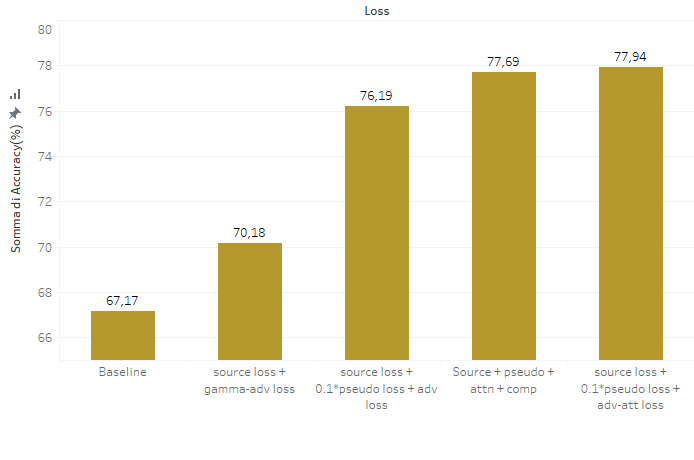

### Real &rarr; Prod

*   Baseline (source loss): 87.47 (last) 87.47 (best)

---


*   DA (source loss + pseudo loss): 88.22 (last) 89.22 (best)
*   DA (source loss + pseudo loss + attn loss): 86.97 (last) 88.97 (best)
*   DA (source loss + pseudo loss + attn loss + comp loss): 84.96 (last) 85.21 (best)

---

*   DA (source loss + adv loss): 87.97 (last) 89.72 (best)
*   DA (source loss + gamma-adv loss): 87.47 (last) 87.47 (best)
*   DA (source loss + adv-attn loss): 88.72 (last) 89.72 (best)
*   DA (source loss + gammas-adv-attn loss): 86.72 (last) 87.97 (best)
*   DA (source loss + 0.1*pseudo loss + adv loss): 89.97 (last) 89.97 (best)
*   DA (source loss + 0.1*pseudo loss + gamma-adv loss): 86.97 (last) 89.22 (best)
*   DA (source loss + 0.1*pseudo loss + adv-attn loss): 89.22 (last) 90.23 (best)
*   DA (source loss + 0.1*pseudo loss + gammas-adv-attn loss): 88.47 (last) 88.47 (best)

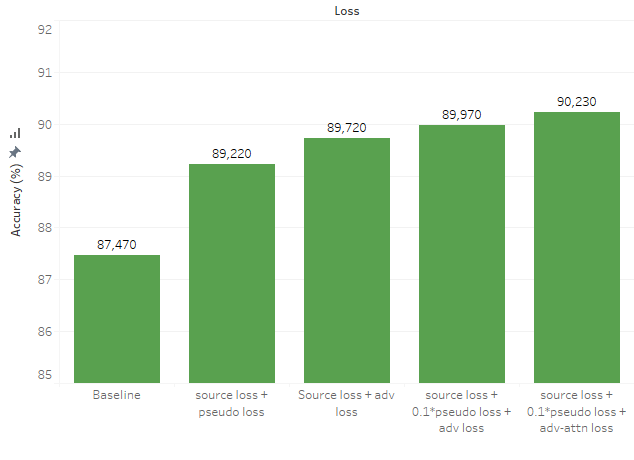